In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import keras
from keras.layers import Activation, Dense, Input, LSTM, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Sequential
from keras.models import Model, load_model
from keras import backend as K
from keras.datasets import mnist
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import mlflow

Using TensorFlow backend.


In [3]:
import datetime
import platform

from pathlib import Path
from os.path import expanduser
from os import path
import logging

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn_evaluation import plot as sk_plot

import yass
from yass import read_config, preprocess, detect
from yass import util as yass_util
from yass.augment import make, util
from yass.augment.noise import noise_cov
from yass.neuralnetwork import evaluate
from yass.explore import RecordingExplorer, SpikeTrainExplorer
from yass.templates import TemplatesProcessor
from yass.geometry import make_channel_index

import numpy as np
from scipy.io import loadmat

from dstools import plot, reproducibility

# logging.basicConfig(level=logging.DEBUG)
savefig = False

In [4]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'retinal/groundtruth_ej49_data1_set1.mat')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')
path_to_geom = path.join(path_to_data, 'retinal/ej49_geometry1.txt')
path_to_here = path.expanduser('~/dev/private-yass/nnet')

mlflow.set_tracking_uri(str(Path(path_to_data, 'mlruns')))

In [5]:
import glob
import yaml

path_to_mlflow = '/home/Edu/data/mlruns'
meta = glob.glob(str(Path(path_to_mlflow, '**/meta.yaml')))

def load_yaml(path):
    with open(path) as f:
        content = yaml.load(f)
    return content

experiments = [load_yaml(p) for p in meta]

def get_id_for_experiment_with_name(name):
    matches = [e['experiment_id'] for e in experiments if e['name'] == name]
    if len(matches):
        return matches[0]
    else:
        return mlflow.create_experiment(name)

experiment_name = 'denoiser-rnn'
EXPERIMENT_ID = get_id_for_experiment_with_name(experiment_name)

In [6]:
print('Running YASS version: {}\nExperiment: {}'
      .format(yass_util.get_version(), experiment_name))

Running YASS version: 062a172 can create several copies of the same template in the same scale with the n_repeat parameter
Experiment: denoiser-rnn


In [7]:
yass.set_config("../config/gcloud/49/default.yaml", 'tmp')
CONFIG = read_config()

## Load clean/noise training set

In [8]:
from  mlflow.tracking import MlflowClient
client = MlflowClient()
experiments = client.list_experiments() 
experiment = client.get_experiment_by_name('denoiser-training-set')
training_set_runs = client.list_run_infos(experiment.experiment_id)

In [9]:
selected = [run for run in training_set_runs if run.run_uuid == 'fd205c908e3246fbbf071b4ba7e84328'][0]

In [10]:
path_to_training_set = Path(selected.artifact_uri, 'dataset.npz')

In [11]:
dataset = np.load(path_to_training_set)

In [12]:
x_train_noisy = dataset['x_train_noisy']
x_train_clean = dataset['x_train_clean']
x_test_noisy = dataset['x_test_noisy']
x_test_clean = dataset['x_test_clean']

In [13]:
selected = np.random.randint(x_test_noisy.shape[0], size=10)

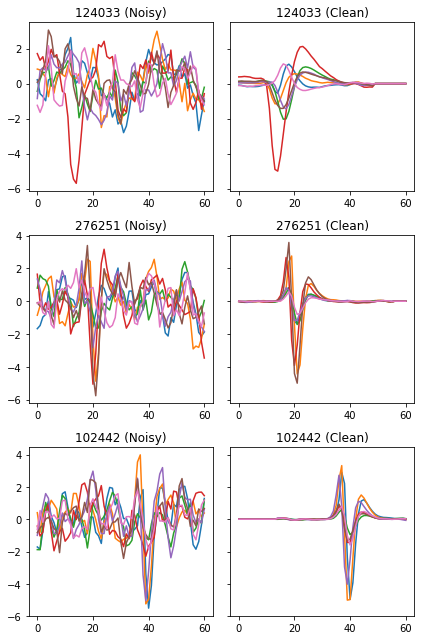

In [14]:
plot.grid_from_array([x_test_noisy,
                      x_test_clean],
                     axis=0,
                     group_names=('Noisy', 'Clean'),
                     elements=selected[:3],
                     auto_figsize=3,
                     sharey='row')

## Processing clean/noise training set

In [22]:
# INPUT FOR THE DENOISER
lookback = 20

to_predict_observations = 1
to_predict_channels = 1

x_train = x_train_noisy[:, :lookback, :]
x_test = x_test_noisy[:, :lookback, :]

y_train = x_train_clean[:, lookback:lookback+to_predict_observations, :to_predict_channels]
y_test = x_test_clean[:,  lookback:lookback+to_predict_observations, :to_predict_channels]

In [23]:
x_train.shape, y_train.shape

((816480, 20, 7), (816480, 1, 1))

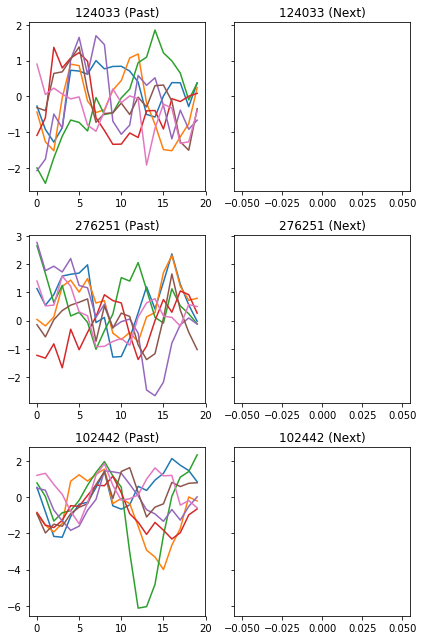

In [24]:
plot.grid_from_array([x_train, y_train],
                     axis=0,
                     elements=selected[:3],
                     auto_figsize=3,
                     group_names=('Past', 'Next'),
                     sharey='row')

In [46]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32,
                     dropout=0,
                     recurrent_dropout=0,
                     return_sequences=True,
                     input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.LSTM(16,
                     dropout=0,
                     recurrent_dropout=0,
                     return_sequences=True))
model.add(layers.LSTM(8,
                     dropout=0,
                     recurrent_dropout=0,
                     return_sequences=False))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 20, 32)            5120      
_________________________________________________________________
lstm_15 (LSTM)               (None, 20, 16)            3136      
_________________________________________________________________
lstm_16 (LSTM)               (None, 8)                 800       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 9,065
Trainable params: 9,065
Non-trainable params: 0
_________________________________________________________________


In [47]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

In [49]:
history = model.fit(x_train, y_train,
                    batch_size=5000,
                    epochs=40,
                    validation_data=(x_test, y_test))

Train on 816480 samples, validate on 349920 samples
Epoch 1/40
485000/816480 [================>.............] - ETA: 12s - loss: 0.1881

ResourceExhaustedError: OOM when allocating tensor with shape[20,5000,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_6/Adam/gradients/lstm_15/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGatherV3 = TensorArrayGatherV3[dtype=DT_FLOAT, element_shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_6/Adam/gradients/lstm_15/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3_grad/TensorArrayGrad/TensorArrayGradV3, lstm_15/TensorArrayUnstack/range, training_6/Adam/gradients/lstm_15/while/TensorArrayReadV3/Enter_1_grad/b_acc_3)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


val: 0.0653

In [50]:
# denoiser.save('/home/Edu/data/denoiser/models/latest.h5')
model.save('/tmp/denoiser.h5')

## Denoising patches

## Denoising simulated recordings

## Denoising recordings

In [97]:
ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)
channel = 0
neighbors = ch_idx[channel]
neighbors

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

In [98]:
exp = RecordingExplorer(path_to_standarized)

In [99]:
n_patches = 1000
offset = 150000

In [100]:
idxs = [(n, n + lookback) for n in range(n_patches)]

In [101]:
patches = np.empty((n_patches, lookback, 7))

for i, (from_, to_) in enumerate(idxs):
    patches[i, :, :] = exp.reader[from_:to_, neighbors]

In [103]:
patches_denoised = np.squeeze(model.predict(patches))

In [106]:
patches_denoised.shape

(1000,)

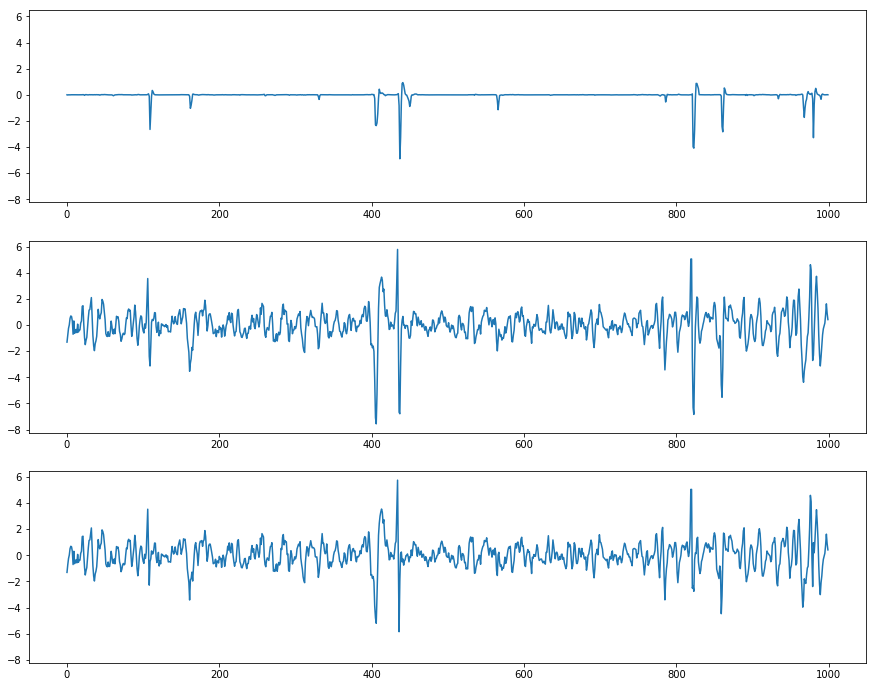

In [109]:
plt.rcParams['figure.figsize'] = (15, 12)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

_ = ax1.plot(patches_denoised)

start = idxs[0][0] + lookback
end = idxs[-1][1] + 1#- lookback

raw = exp.reader[start:end, channel]
_ = ax2.plot(raw)

_ = ax3.plot(raw - patches_denoised)